In [1]:
%env XLA_FLAGS=--xla_gpu_deterministic_ops=true
%env CUDA_VISIBLE_DEVICES=2
from earth2studio.models.px.graphcast import GraphCastMini
from graphcast import data_utils
import xarray as xr
import dataclasses
from graphcast import rollout
from graphcast import data_utils
import jax
import numpy as np
from earth2studio.utils.time import to_time_array

env: XLA_FLAGS=--xla_gpu_deterministic_ops=true
env: CUDA_VISIBLE_DEVICES=2


In [2]:
pkg = GraphCastMini.load_default_package()
model = GraphCastMini.load_model(pkg)

In [3]:
 # from gs://dm_graphcast/dataset/source-era5_date-2022-01-01_res-0.25_levels-13_steps-04.nc
example_batch = xr.open_dataset("../data/source-era5_date-2022-01-01_res-1.0_levels-13_steps-04.nc").compute()
print(example_batch)

<xarray.Dataset> Size: 132MB
Dimensions:                       (lon: 360, lat: 181, level: 13, time: 6,
                                   batch: 1)
Coordinates:
  * lon                           (lon) float32 1kB 0.0 1.0 2.0 ... 358.0 359.0
  * lat                           (lat) float32 724B -90.0 -89.0 ... 89.0 90.0
  * level                         (level) int32 52B 50 100 150 ... 850 925 1000
  * time                          (time) timedelta64[ns] 48B 00:00:00 ... 1 d...
    datetime                      (batch, time) datetime64[ns] 48B 2022-01-01...
Dimensions without coordinates: batch
Data variables: (12/14)
    geopotential_at_surface       (lat, lon) float32 261kB 2.735e+04 ... -0.0...
    land_sea_mask                 (lat, lon) float32 261kB 1.0 1.0 ... 0.0 0.0
    2m_temperature                (batch, time, lat, lon) float32 2MB 250.7 ....
    mean_sea_level_pressure       (batch, time, lat, lon) float32 2MB 9.931e+...
    10m_v_component_of_wind       (batch, time, lat, 

In [4]:

eval_inputs, eval_targets, eval_forcings = data_utils.extract_inputs_targets_forcings(
    example_batch, target_lead_times=slice("6h", "12h"),
    **dataclasses.asdict(model.ckpt.task_config))
print(eval_targets)
generator = rollout.chunked_prediction_generator(model.run_forward,
rng=jax.random.PRNGKey(0),
inputs=eval_inputs,
targets_template=eval_targets * np.nan,
forcings=eval_forcings)
prediction_graphcast = [next(generator) for _ in range(2)]
print(prediction_graphcast)

<xarray.Dataset> Size: 43MB
Dimensions:                  (batch: 1, time: 2, lat: 181, lon: 360, level: 13)
Coordinates:
  * lon                      (lon) float32 1kB 0.0 1.0 2.0 ... 357.0 358.0 359.0
  * lat                      (lat) float32 724B -90.0 -89.0 -88.0 ... 89.0 90.0
  * level                    (level) int32 52B 50 100 150 200 ... 850 925 1000
  * time                     (time) timedelta64[ns] 16B 06:00:00 12:00:00
Dimensions without coordinates: batch
Data variables:
    2m_temperature           (batch, time, lat, lon) float32 521kB 247.3 ... ...
    mean_sea_level_pressure  (batch, time, lat, lon) float32 521kB 1.003e+05 ...
    10m_v_component_of_wind  (batch, time, lat, lon) float32 521kB 0.03759 .....
    10m_u_component_of_wind  (batch, time, lat, lon) float32 521kB 0.4077 ......
    total_precipitation_6hr  (batch, time, lat, lon) float32 521kB 8.821e-06 ...
    temperature              (batch, time, level, lat, lon) float32 7MB 238.8...
    geopotential         

[<xarray.Dataset> Size: 22MB
Dimensions:                  (time: 1, batch: 1, lat: 181, lon: 360, level: 13)
Coordinates:
  * lon                      (lon) float32 1kB 0.0 1.0 2.0 ... 357.0 358.0 359.0
  * lat                      (lat) float32 724B -90.0 -89.0 -88.0 ... 89.0 90.0
  * level                    (level) int32 52B 50 100 150 200 ... 850 925 1000
  * time                     (time) timedelta64[ns] 8B 06:00:00
Dimensions without coordinates: batch
Data variables:
    10m_u_component_of_wind  (time, batch, lat, lon) float32 261kB xarray_jax...
    10m_v_component_of_wind  (time, batch, lat, lon) float32 261kB xarray_jax...
    2m_temperature           (time, batch, lat, lon) float32 261kB xarray_jax...
    geopotential             (time, batch, level, lat, lon) float32 3MB xarra...
    mean_sea_level_pressure  (time, batch, lat, lon) float32 261kB xarray_jax...
    specific_humidity        (time, batch, level, lat, lon) float32 3MB xarra...
    temperature              (time

In [5]:
tensor= model.iterator_result_to_tensor(example_batch.isel(time=slice(0,2)).drop_vars("toa_incident_solar_radiation"))
tensor.shape

torch.Size([1, 1, 2, 85, 181, 360])

In [6]:
from collections import OrderedDict
time = ["2022-01-01T12:00:00"]
prognostic = model
device=None
output_coords=OrderedDict({})
nsteps=2

In [7]:
prognostic_ic = prognostic.input_coords()
time = to_time_array(time)

coords = prognostic_ic.copy()
coords["time"] = time
x = tensor

#res, coords = model(x,coords)
coords["batch"] = np.array([0])
print(coords.keys())

m = prognostic.create_iterator(x, coords)

pediction_e2s = []
for step, (x, coords) in enumerate(m):
    print(x.shape)
    print(coords.keys())
    pediction_e2s.append(x)
    if step == nsteps:
        break


odict_keys(['batch', 'time', 'lead_time', 'variable', 'lat', 'lon'])


torch.Size([1, 1, 1, 85, 181, 360])
odict_keys(['batch', 'time', 'lead_time', 'variable', 'lat', 'lon'])


torch.Size([1, 1, 1, 85, 181, 360])
odict_keys(['batch', 'time', 'lead_time', 'variable', 'lat', 'lon'])
torch.Size([1, 1, 1, 85, 181, 360])
odict_keys(['batch', 'time', 'lead_time', 'variable', 'lat', 'lon'])


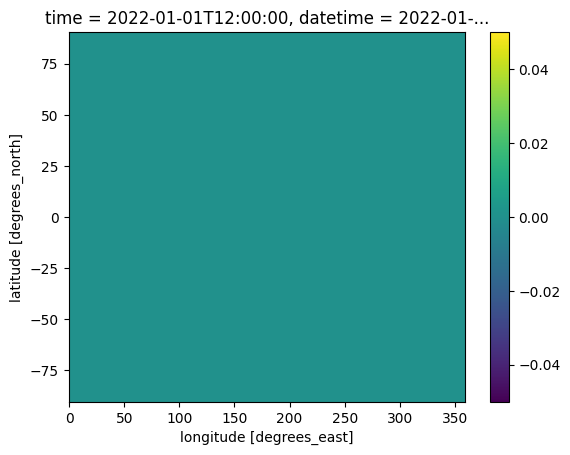

In [8]:
# IC is the same
(example_batch["2m_temperature"].isel(time=1) - xr.DataArray(pediction_e2s[0], coords=coords).sel(variable="t2m").isel(lead_time=0)).plot()

In [9]:
da = xr.DataArray(pediction_e2s[1], coords=coords)
da

<xarray.DataArray (batch: 1, time: 1, lead_time: 1, variable: 85, lat: 181,
                   lon: 360)> Size: 22MB
array([[[[[[ 2.52299072e+02,  2.52237915e+02,  2.52278687e+02, ...,
             2.52299072e+02,  2.52278687e+02,  2.52299072e+02],
           [ 2.52106400e+02,  2.52070190e+02,  2.51991638e+02, ...,
             2.52207138e+02,  2.52214844e+02,  2.52141022e+02],
           [ 2.50996674e+02,  2.50941422e+02,  2.50765442e+02, ...,
             2.51141647e+02,  2.51073959e+02,  2.51075302e+02],
           ...,
           [ 2.49356018e+02,  2.49292343e+02,  2.49215302e+02, ...,
             2.49673660e+02,  2.49531372e+02,  2.49458038e+02],
           [ 2.48998260e+02,  2.48944489e+02,  2.48925400e+02, ...,
             2.49157120e+02,  2.49077637e+02,  2.49048477e+02],
           [ 2.47890457e+02,  2.47903198e+02,  2.47905746e+02, ...,
             2.47893005e+02,  2.47880264e+02,  2.47890457e+02]],

          [[ 9.97097891e+04,  9.97129141e+04,  9.97097891e+04, ...,
             9.97108281e+04,  9.97097891e+04,  9.97087422e+04],
           [ 9.97449297e+04,  9.97502266e+04,  9.97533828e+04, ...,
             9.97338125e+04,  9.97376562e+04,  9.97393281e+04],
           [ 9.97828594e+04,  9.97866562e+04,  9.97916406e+04, ...,
             9.97666172e+04,  9.97722422e+04,  9.97760859e+04],
...
             0.00000000e+00,  0.00000000e+00,  0.00000000e+00],
           [ 0.00000000e+00,  0.00000000e+00,  0.00000000e+00, ...,
             0.00000000e+00,  0.00000000e+00,  0.00000000e+00],
           [ 0.00000000e+00,  0.00000000e+00,  0.00000000e+00, ...,
             0.00000000e+00,  0.00000000e+00,  0.00000000e+00]],

          [[ 0.00000000e+00,  0.00000000e+00,  0.00000000e+00, ...,
             0.00000000e+00,  0.00000000e+00,  0.00000000e+00],
           [ 0.00000000e+00,  0.00000000e+00,  0.00000000e+00, ...,
             0.00000000e+00,  0.00000000e+00,  0.00000000e+00],
           [ 0.00000000e+00,  0.00000000e+00,  0.00000000e+00, ...,
             0.00000000e+00,  0.00000000e+00,  0.00000000e+00],
           ...,
           [ 0.00000000e+00,  0.00000000e+00,  0.00000000e+00, ...,
             0.00000000e+00,  0.00000000e+00,  0.00000000e+00],
           [ 0.00000000e+00,  0.00000000e+00,  0.00000000e+00, ...,
             0.00000000e+00,  0.00000000e+00,  0.00000000e+00],
           [ 0.00000000e+00,  0.00000000e+00,  0.00000000e+00, ...,
             0.00000000e+00,  0.00000000e+00,  0.00000000e+00]]]]]],
      shape=(1, 1, 1, 85, 181, 360), dtype=float32)
Coordinates:
  * batch      (batch) int64 8B 0
  * time       (time) datetime64[ns] 8B 2022-01-01T12:00:00
  * lead_time  (lead_time) timedelta64[s] 8B 12:00:00
  * variable   (variable) <U5 2kB 't2m' 'msl' 'u10m' ... 'q1000' 'z' 'lsm'
  * lat        (lat) float64 1kB -90.0 -89.0 -88.0 -87.0 ... 87.0 88.0 89.0 90.0
  * lon        (lon) float64 3kB 0.0 1.0 2.0 3.0 4.0 ... 356.0 357.0 358.0 359.0

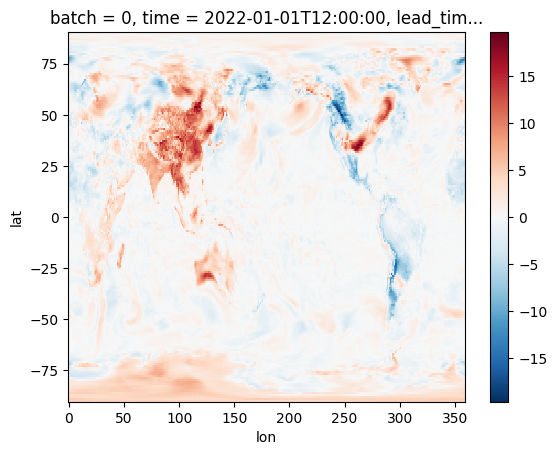

In [14]:
# prediction is not the same
(da.sel(variable="t2m") - prediction_graphcast[0]["2m_temperature"].isel(time=0)).plot()